**Вежба за Глава 3 - Рекурентни невронски мрежи (Предвидување на временски серии)**

Кодот е изваден и адаптиран од https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Податочно множество**

Се презема податочното множество "Jena Climate" од Макс-Планк институтот за Биогеохемија во Јена, Германија, кое содржи мерења на 14 параметри како температура, влажност, атмосферски притисок, и.т.н. на интервали од 10 минути во периодот од 10.01.2009 до 31.12.2016. Множеството е средено од François Chollet.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Мерењата се правени на 10 минути, а во овој пример се земаат само мерењата на секој час, па се семплира множеството, т.е. се зема секој шести примерок.

In [ ]:
df = pd.read_csv(csv_path)
# Исечкај [start:stop:step], почнувајќи од индекс 5 земај го секој шести запис.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head(5)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


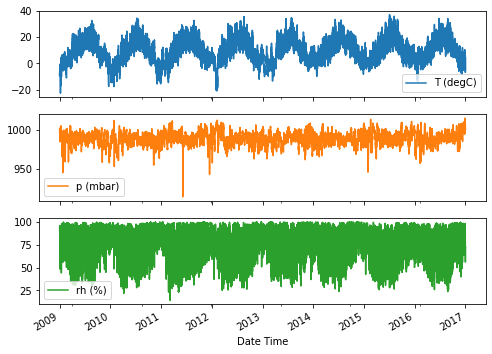

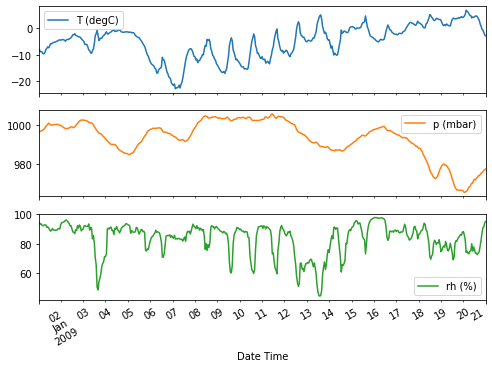

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rh (%)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Се поправаат некои грешки во податоците, каде во некои записи има негативни вредности за брзината на ветрот.

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0



Се воведува нова променлива вектор на ветер која е попогодна во моделот.

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Претвори во радијани.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Пресметај ги x и y компонентите на ветарот.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Најди ги максималните x и y компоненти на ветарот.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Се конвертира времето од стринг во периодични величини како Време од денот и Време од годината.

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Ден (sin)'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Ден (cos)'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Година (sin)'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Година (cos)'] = np.cos(timestamp_s * (2 * np.pi / year))

Податочното множество се дели на три дела за учење (70%), валидација (15%) и тестирање (15%).

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]
print(num_features)
num_training_samples=train_df.shape[0]
print(num_training_samples)

19
49063


Се прави нормализација на податоците со одземање на средните вредности и делење со стандардната девиација.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

WindowGenerator класа која се користи за генерирање на различни типови на податочни прозорци.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Зачувај ги сировите податоци.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Средување на индексите на колоните со лабели.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Средување на параматрите на прозорецот.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

split_window метод за делење на податоците во прозорци

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Сецкањето не ја задржува статичката информација за формата, па формата се поставува рачно. На овој начин `tf.data.Datasets` полесно се контролираат.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 3*max_subplots))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [норм.]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Влезови', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Лабели', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Предвидувања',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Време [h]')

WindowGenerator.plot = plot

Дефинирање на функција за компајлирање и фитување на моделите која користи MSE како функција на загуба, Адам оптимизатор и MAE како метрика за евалуација и поставување на максимален број на епохи.

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history



***I. Предвидување на еден чекор***

**Предвидување на еден излез**

Креирање на модели за предвидување на еден излез, во овој случај температура.

In [ ]:
singleoutput_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

singleoutput_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [ ]:
val_performance_singleoutput = {}
performance_singleoutput = {}

LSTM

In [ ]:
singleoutput_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [ ]:
print('Влезна форма:', singleoutput_window.example[0].shape)
print('Излезна форма:', singleoutput_lstm_model(singleoutput_window.example[0]).shape)

Влезна форма: (32, 24, 19)
Излезна форма: (32, 24, 1)


In [ ]:
history = compile_and_fit(singleoutput_lstm_model, singleoutput_window)

Epoch 1/10
1533/1533 [==============================] - 28s 17ms/step - loss: 0.0301 - mean_absolute_error: 0.0965 - val_loss: 0.0071 - val_mean_absolute_error: 0.0591
Epoch 2/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0064 - mean_absolute_error: 0.0560 - val_loss: 0.0064 - val_mean_absolute_error: 0.0552
Epoch 3/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0060 - mean_absolute_error: 0.0538 - val_loss: 0.0062 - val_mean_absolute_error: 0.0542
Epoch 4/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0059 - mean_absolute_error: 0.0529 - val_loss: 0.0062 - val_mean_absolute_error: 0.0543
Epoch 5/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0057 - mean_absolute_error: 0.0522 - val_loss: 0.0060 - val_mean_absolute_error: 0.0531
Epoch 6/10
1533/1533 [==============================] - 25s 16ms/step - loss: 0.0056 - mean_absolute_error: 0.0517 - val_loss: 0.0061 - val_mean_absolute_error:

In [ ]:
val_performance_singleoutput['LSTM'] = singleoutput_lstm_model.evaluate(singleoutput_window.val, verbose=1)
performance_singleoutput['LSTM'] = singleoutput_lstm_model.evaluate(singleoutput_window.test, verbose=1)

328/328 [==============================] - 2s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0514


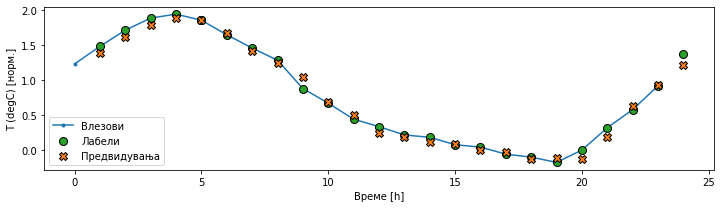

In [ ]:
singleoutput_window.plot(singleoutput_lstm_model,max_subplots=1)

GRU

In [ ]:
singleoutput_gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(singleoutput_gru_model, singleoutput_window)

Epoch 1/10
1533/1533 [==============================] - 30s 18ms/step - loss: 0.0110 - mean_absolute_error: 0.0700 - val_loss: 0.0068 - val_mean_absolute_error: 0.0576
Epoch 2/10
1533/1533 [==============================] - 27s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0559 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561
Epoch 3/10
1533/1533 [==============================] - 27s 18ms/step - loss: 0.0061 - mean_absolute_error: 0.0542 - val_loss: 0.0062 - val_mean_absolute_error: 0.0546
Epoch 4/10
1533/1533 [==============================] - 28s 18ms/step - loss: 0.0059 - mean_absolute_error: 0.0532 - val_loss: 0.0062 - val_mean_absolute_error: 0.0542
Epoch 5/10
1533/1533 [==============================] - 27s 18ms/step - loss: 0.0058 - mean_absolute_error: 0.0525 - val_loss: 0.0061 - val_mean_absolute_error: 0.0539
Epoch 6/10
1533/1533 [==============================] - 27s 18ms/step - loss: 0.0057 - mean_absolute_error: 0.0520 - val_loss: 0.0060 - val_mean_absolute_error:

In [ ]:
val_performance_singleoutput['GRU'] = singleoutput_gru_model.evaluate( singleoutput_window.val, verbose=1)
performance_singleoutput['GRU'] = singleoutput_gru_model.evaluate( singleoutput_window.test, verbose=1)

328/328 [==============================] - 2s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0509


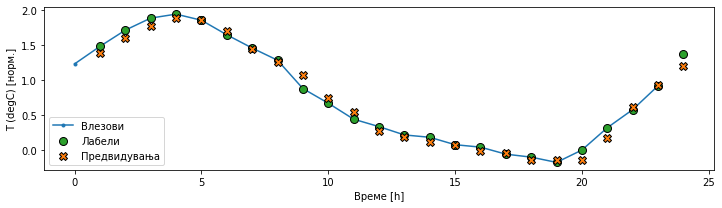

In [ ]:
singleoutput_window.plot(singleoutput_gru_model,max_subplots=1)

CNN-LSTM

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

singleoutput_convlstm2d_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.LSTM(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(singleoutput_convlstm2d_model, conv_window)

Epoch 1/10
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0213 - mean_absolute_error: 0.0876 - val_loss: 0.0077 - val_mean_absolute_error: 0.0628
Epoch 2/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0077 - mean_absolute_error: 0.0629 - val_loss: 0.0075 - val_mean_absolute_error: 0.0604
Epoch 3/10
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0071 - mean_absolute_error: 0.0598 - val_loss: 0.0074 - val_mean_absolute_error: 0.0623
Epoch 4/10
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0069 - mean_absolute_error: 0.0588 - val_loss: 0.0072 - val_mean_absolute_error: 0.0595
Epoch 5/10
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0067 - mean_absolute_error: 0.0577 - val_loss: 0.0069 - val_mean_absolute_error: 0.0593
Epoch 6/10
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0579 - val_loss: 0.0068 - val_mean_absolute_error: 0.056

In [ ]:
val_performance_singleoutput['CNN-LSTM'] = singleoutput_convlstm2d_model.evaluate(conv_window.val, verbose=1)
performance_singleoutput['CNN-LSTM'] = singleoutput_convlstm2d_model.evaluate(conv_window.test, verbose=1)

329/329 [==============================] - 2s 4ms/step - loss: 0.0054 - mean_absolute_error: 0.0518


Како што може да се забележи CNN-LSTM моделот има полоши перформанси иако има поголема комплексност, бидејќи не е соодветен за предвидување на временски серии, па понатаму во примерот нема да биде користен. Од друга страна, овој модел е ефикасен за проблеми кои вклучуваат препознавање на патерни во временски серии, како на пример при Human activity recognition (HAR).

Споредба на перформансите на моделите

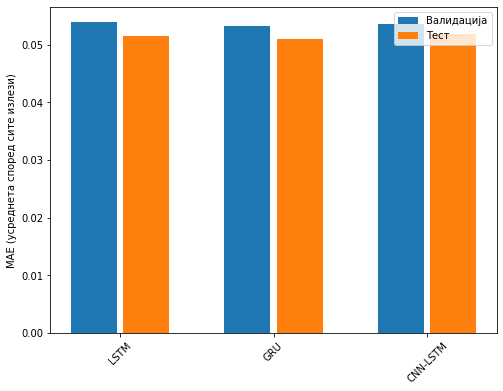

In [ ]:
x = np.arange(len(performance_singleoutput))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = singleoutput_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_singleoutput.values()]
test_mae = [v[metric_index] for v in performance_singleoutput.values()]

plt.bar(x - 0.17, val_mae, width, label='Валидација')
plt.bar(x + 0.17, test_mae, width, label='Тест')
plt.xticks(ticks=x, labels=performance_singleoutput.keys(),
           rotation=45)
plt.ylabel('MAE (усреднета според сите излези)')
_ = plt.legend()

*Самостојна задача*: Пробајте да го менувате бројот на јазли во скриените слоеви на моделите и/или активациската функција и како тоа влијае на нивната прецизност. Испробајте употреба на други оптимизатори и метрики.

*Самостојна задача*: Пробајте да ја направите истата анализа со претходните модели, но овојпат за предвидување на некоја друга променлива, како на пример атмосферскиот притисок.

**Предвидување на повеќе излези**

Со претходниот модел се предвидуваше само температурата. На сличен начин може да се креира и модел кој ќе предвидува повеќе излези одеднаш со додавање на дополнителни единици во излезниот слој, по една за секоја променлива која сакаме да ја предвидуваме. Во наредните модели ќе се предвидуваат температура, атмосферски притисок и релативна влажност.

In [ ]:
multioutput_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)','p (mbar)', 'rh (%)'])

multioutput_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)', 'p (mbar)', 'rh (%)']

In [ ]:
val_performance_multioutput = {}
performance_multioutput = {}

LSTM

In [ ]:
%%time

multioutput_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3)
])

history = compile_and_fit(multioutput_lstm_model, multioutput_window)

val_performance_multioutput['LSTM'] = multioutput_lstm_model.evaluate(multioutput_window.val)
performance_multioutput['LSTM'] = multioutput_lstm_model.evaluate(multioutput_window.test, verbose=0)

Epoch 1/10
1533/1533 [==============================] - 28s 17ms/step - loss: 0.0670 - mean_absolute_error: 0.1469 - val_loss: 0.0235 - val_mean_absolute_error: 0.0898
Epoch 2/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0201 - mean_absolute_error: 0.0825 - val_loss: 0.0203 - val_mean_absolute_error: 0.0811
Epoch 3/10
1533/1533 [==============================] - 25s 16ms/step - loss: 0.0187 - mean_absolute_error: 0.0779 - val_loss: 0.0196 - val_mean_absolute_error: 0.0791
Epoch 4/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0182 - mean_absolute_error: 0.0763 - val_loss: 0.0192 - val_mean_absolute_error: 0.0777
Epoch 5/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0178 - mean_absolute_error: 0.0755 - val_loss: 0.0191 - val_mean_absolute_error: 0.0775
Epoch 6/10
1533/1533 [==============================] - 25s 17ms/step - loss: 0.0176 - mean_absolute_error: 0.0747 - val_loss: 0.0189 - val_mean_absolute_error:

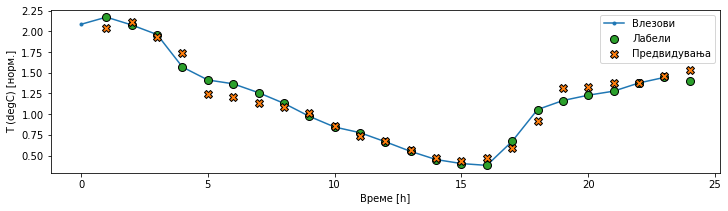

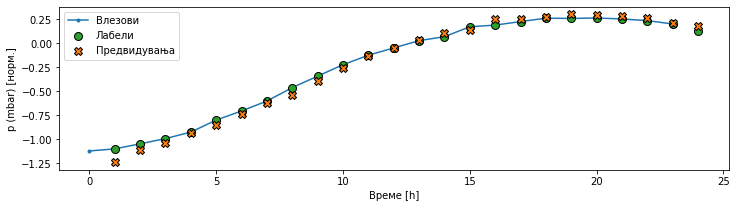

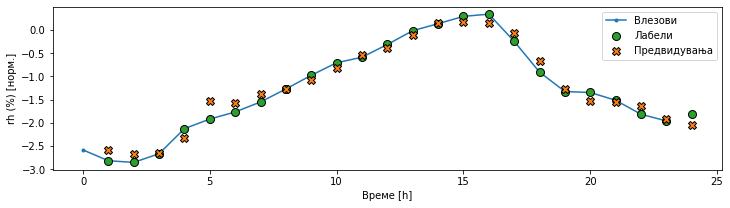

In [ ]:
multioutput_window.plot(multioutput_lstm_model, plot_col='T (degC)', max_subplots=1)
multioutput_window.plot(multioutput_lstm_model, plot_col='p (mbar)', max_subplots=1)
multioutput_window.plot(multioutput_lstm_model, plot_col='rh (%)', max_subplots=1)

GRU

In [ ]:
multioutput_gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3)
])

history = compile_and_fit(multioutput_gru_model, multioutput_window)

val_performance_multioutput['GRU'] = multioutput_gru_model.evaluate(multioutput_window.val)
performance_multioutput['GRU'] = multioutput_gru_model.evaluate(multioutput_window.test, verbose=0)

Epoch 1/10
1533/1533 [==============================] - 29s 17ms/step - loss: 0.0512 - mean_absolute_error: 0.1283 - val_loss: 0.0215 - val_mean_absolute_error: 0.0861
Epoch 2/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0196 - mean_absolute_error: 0.0815 - val_loss: 0.0201 - val_mean_absolute_error: 0.0810
Epoch 3/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0189 - mean_absolute_error: 0.0788 - val_loss: 0.0196 - val_mean_absolute_error: 0.0791
Epoch 4/10
1533/1533 [==============================] - 27s 17ms/step - loss: 0.0184 - mean_absolute_error: 0.0774 - val_loss: 0.0194 - val_mean_absolute_error: 0.0789
Epoch 5/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0181 - mean_absolute_error: 0.0765 - val_loss: 0.0191 - val_mean_absolute_error: 0.0774
Epoch 6/10
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0178 - mean_absolute_error: 0.0757 - val_loss: 0.0189 - val_mean_absolute_error:

Споредба на перформанси

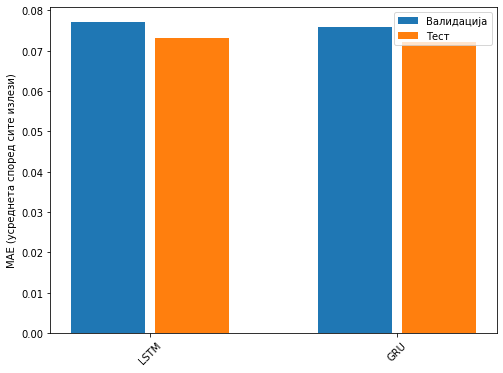

In [ ]:
x = np.arange(len(performance_multioutput))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multioutput_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_multioutput.values()]
test_mae = [v[metric_index] for v in performance_multioutput.values()]

plt.bar(x - 0.17, val_mae, width, label='Валидација')
plt.bar(x + 0.17, test_mae, width, label='Тест')
plt.xticks(ticks=x, labels=performance_multioutput.keys(),
           rotation=45)
plt.ylabel('MAE (усреднета според сите излези)')
_ = plt.legend()

In [ ]:
for name, value in performance_multioutput.items():
  print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 0.0731
GRU            : 0.0723


***II. Предвидување на повеќе чекори***

Следните модели се креирани за предвидување на повеќе идни чекори одеднаш. Бројот на чекори кои се предвидуваат се задава со променливата OUT_STEPS. Како излезни променливи се избрани повторно температура, атосмферски притисок и релативна влажност.

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['T (degC)','p (mbar)', 'rh (%)'])

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)', 'p (mbar)', 'rh (%)']

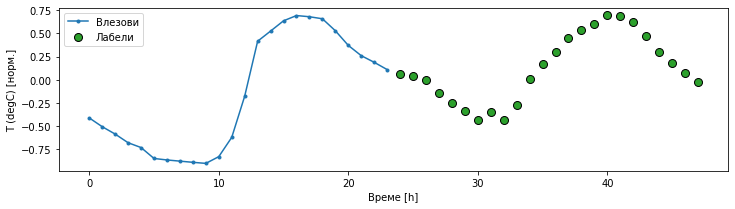

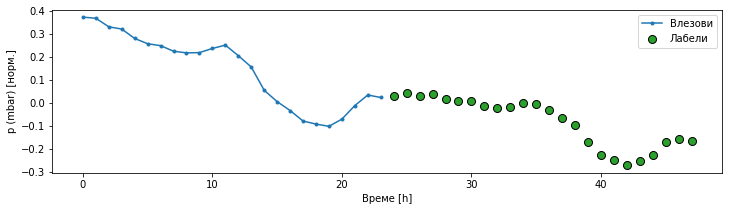

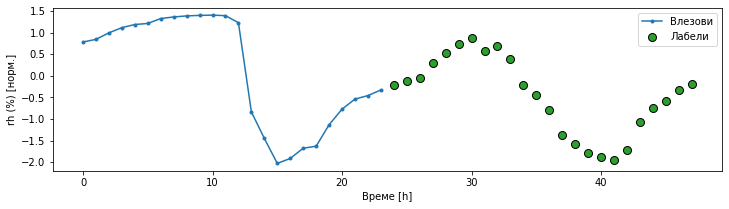

In [ ]:
multi_window.plot(plot_col='T (degC)',max_subplots=1)
multi_window.plot(plot_col='p (mbar)',max_subplots=1)
multi_window.plot(plot_col='rh (%)',max_subplots=1)


In [ ]:
multi_val_performance = {}
multi_performance = {}

LSTM

In [72]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 3])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=1)



Epoch 1/10
1532/1532 [==============================] - 28s 16ms/step - loss: 0.2694 - mean_absolute_error: 0.3732 - val_loss: 0.2092 - val_mean_absolute_error: 0.3278
Epoch 2/10
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1951 - mean_absolute_error: 0.3123 - val_loss: 0.2020 - val_mean_absolute_error: 0.3186
Epoch 3/10
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1853 - mean_absolute_error: 0.3022 - val_loss: 0.1965 - val_mean_absolute_error: 0.3110
Epoch 4/10
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1796 - mean_absolute_error: 0.2965 - val_loss: 0.1929 - val_mean_absolute_error: 0.3070
Epoch 5/10
1532/1532 [==============================] - 25s 16ms/step - loss: 0.1753 - mean_absolute_error: 0.2924 - val_loss: 0.1964 - val_mean_absolute_error: 0.3114
Epoch 6/10
328/328 [==============================] - 2s 6ms/step - loss: 0.1795 - mean_absolute_error: 0.2991


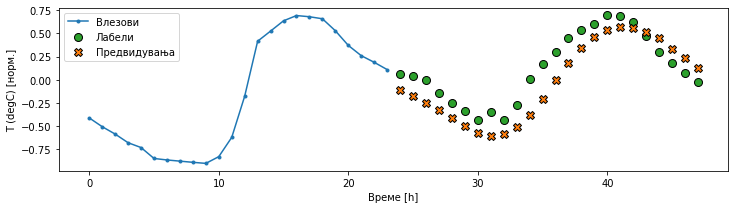

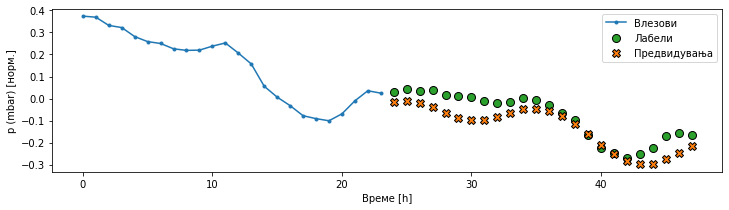

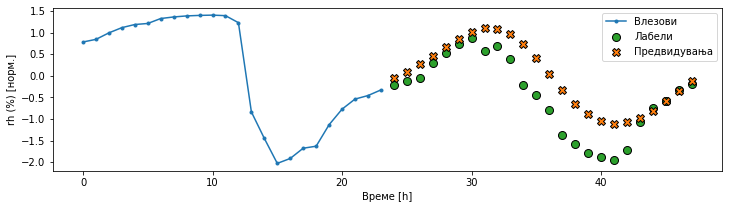

In [73]:
multi_window.plot(multi_lstm_model,plot_col='T (degC)',max_subplots=1)
multi_window.plot(multi_lstm_model,plot_col='p (mbar)',max_subplots=1)
multi_window.plot(multi_lstm_model,plot_col='rh (%)',max_subplots=1)

GRU

In [71]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 3])
])

history = compile_and_fit(multi_gru_model, multi_window)

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=1)

Epoch 1/10
1532/1532 [==============================] - 28s 17ms/step - loss: 0.2603 - mean_absolute_error: 0.3662 - val_loss: 0.2090 - val_mean_absolute_error: 0.3260
Epoch 2/10
1532/1532 [==============================] - 26s 17ms/step - loss: 0.2010 - mean_absolute_error: 0.3166 - val_loss: 0.2001 - val_mean_absolute_error: 0.3157
Epoch 3/10
1532/1532 [==============================] - 27s 17ms/step - loss: 0.1917 - mean_absolute_error: 0.3068 - val_loss: 0.1957 - val_mean_absolute_error: 0.3109
Epoch 4/10
1532/1532 [==============================] - 27s 17ms/step - loss: 0.1862 - mean_absolute_error: 0.3012 - val_loss: 0.1928 - val_mean_absolute_error: 0.3064
Epoch 5/10
1532/1532 [==============================] - 26s 17ms/step - loss: 0.1820 - mean_absolute_error: 0.2972 - val_loss: 0.1913 - val_mean_absolute_error: 0.3053
Epoch 6/10
1532/1532 [==============================] - 25s 17ms/step - loss: 0.1788 - mean_absolute_error: 0.2941 - val_loss: 0.1914 - val_mean_absolute_error:

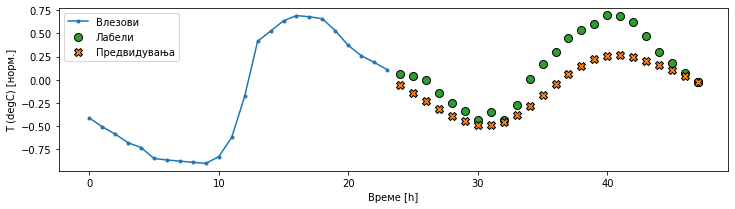

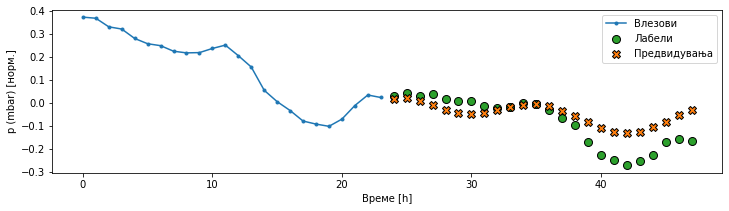

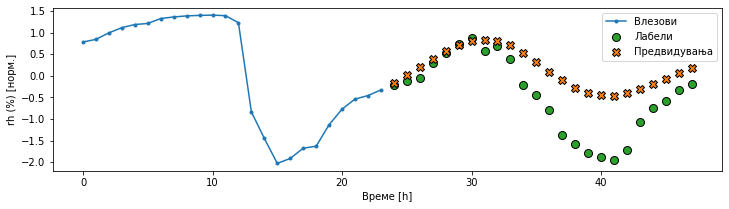

In [74]:
multi_window.plot(multi_gru_model,plot_col='T (degC)',max_subplots=1)
multi_window.plot(multi_gru_model,plot_col='p (mbar)',max_subplots=1)
multi_window.plot(multi_gru_model,plot_col='rh (%)',max_subplots=1)

Перформанси


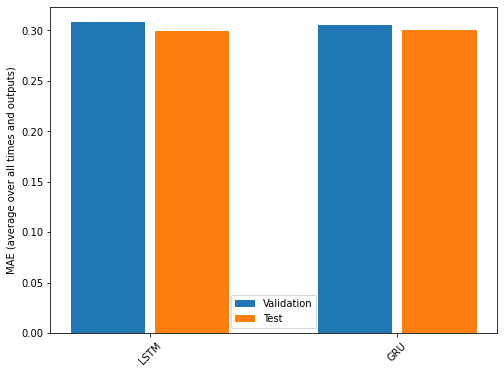

In [75]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multioutput_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [76]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.2991
GRU     : 0.3007


*Самостојна задача*: Пробајте да ги извршите моделите во авторегресивен режим, при што во секој чекор се прави предвидување само на следниот чекор, а потоа добиениот излез се носи на влез за да се направи ново предвидување на следниот чекор, итн.